### Disclaimer

The following notebook was compiled for the course 'Geostatistics' at Ghent University (lecturer-in-charge: Prof. Dr. Ellen Van De Vijver; teaching assistant: Pablo De Weerdt). It consists primarily of notebook snippets created by Michael Pyrcz. The code and markdown (text) snippets were edited specifically for this course, using the 'Jura data set' (Goovaerts, 1997) as example in the practical classes. Some new code snippets are also included to cover topics which were not found in the Geostastpy package demo books.<br> 

This notebook is for educational purposes.<br> 

Guidelines for getting started were adapted from the 'Environmental Soil Sensing' course at Ghent University (lecturer-in-charge: Prof. Dr. Philippe De Smedt).<br> 

The Jura data set was taken from: Goovaerts P., 1997. Geostatistics for Natural Resources Evaluation. Oxford University Press.

# Geostatistics: Introduction to geostatistical data analysis with Python

### Getting Started


---
This introductory notebook will help you perform an explorative analysis of spatial data, and help get you acquainted with basic data operations in Python. It contains code that you can readily use in the Geostatistics practical sessions.<br> 

**First of all, make sure to save a copy of this notebook**. In Google Colab, you can do this by navigating to the top menu, click 'File', 'Save a copy in Drive'. Make sure to give an appropriate name to your copy, in this context, for example, the name of the original notebook can be followed by your name or initials.<br> 

This [jupyter notebook](https://docs.jupyter.org/en/latest/) is made up of text cells (markdown) like this one, and code cells (with [Python](https://docs.python.org/3/tutorial/) code), such as the two cells below these. Note that in code cells, there also is text (comments), which is preceded by a hash (`# This is a comment`) or placed between two or three quatation marks (`'''This is a comment'''`).

In these first cell you will install and import specific packages (ready-made sets of code) that you will use to perform analyses in this notebook. The install script has functionality in Colab, Jupyter as well as in standard integrated development environmnents (IDEs).

If you are unfamiliar with Python code and Jupyter notebooks, you find some introductory notebooks in the [DS-python-geospatial repository](https://github.com/jorisvandenbossche/DS-python-geospatial/tree/main/notebooks), developed by Joris Van den Bossche. However, since you can run this notebook with Google Colab, all steps are automated and you should have a smooth experience in using all this! Extensive documentation is provided in these code cells to help you along the way.

---

There is a lot of Python code in this notebook. While you are free to modify the code as you want, in cases where you can perform specific operations or data analyses, the part of the code where you can modify variables, or write functions, always appears above a commented line of asterisks, like this: `# ******* `. The part below the asterisk line is where the rest of the code that is required to perform the operation is written, but to complete the practiical exercise you are not required to change anything.

If no asterisk line is present in a code cell, this means you can simply run the code cell without changing anything to get the output.

In [1]:
# Import required packages for setup
# -------------------------------------------- #

import sys
import os

In [ ]:
#  Clone the repository and add it to the path
if 'google.colab' in sys.modules:
    !git clone https://github.com/SENSE-UGent/E_I002454_Geostatistics.git
    sys.path.append('/content/E_I002454_Geostatistics') #Default location in Google Colab after cloning
else:
    # if you are not using Google Colab, change the path to the location of the repository
    sys.path.append(r'c:\Users\pdweerdt\Documents\Repos\E_I002454_Geostatistics')
    
# Import the setup function
from Utils.setup import check_and_install_packages

# Read the requirements.txt file
if 'google.colab' in sys.modules:
    requirements_path = '/content/E_I002454_Geostatistics/Utils/requirements.txt'
else:
    requirements_path = 'c:/Users/pdweerdt/Documents/Repos/E_I002454_Geostatistics/Utils/requirements.txt'

with open(requirements_path) as f:
    required_packages = f.read().splitlines()

# Check and install packages
check_and_install_packages(required_packages)

#### Load Required libraries

In [2]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
# import geostatspy.geostats as geostats                      # GSLIB methods convert to Python  
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))   # these notebooks were tested with GeostatsPy version: 0.0.72

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed.

In [3]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)
                                   
import numpy as np                                            # ndarrays for gridded data
                                       
import pandas as pd                                           # DataFrames for tabular data

import matplotlib as mpl                                        
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap 
import matplotlib.ticker as mtick 
import matplotlib.gridspec as gridspec

from scipy import stats                                       # summary statistics
from scipy.stats import pearsonr                              # Pearson product moment correlation
from scipy.stats import spearmanr                             # spearman rank correlation    
                                   
import seaborn as sns                                         # advanced plotting

plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements

ignore_warnings = True                                        # ignore warnings?
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')

from IPython.utils import io                                  # mute output from simulation

seed = 42                                                     # random number seed

### Set the Working Directory

Do this to simplify subsequent reads and writes (avoid including the full address each time). 

##### For use in Google Colab

Run the following cell if you automatically want to get the data from the repository and store it on your Google Colab drive

In [ ]:
# change the working directory to the cloned repository

os.chdir('E_I002454_Geostatistics')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

##### For local use

Only run the following cell if you have the data locally stored.

In [4]:
# set the working directory, place an r in front to address special characters
os.chdir(r'C:\\Users\\pdweerdt\\OneDrive - UGent\\I002454 - Geostatistics\\AY 2024-2025\\Practicals')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  C:\Users\pdweerdt\OneDrive - UGent\I002454 - Geostatistics\AY 2024-2025\Practicals


#### Loading Tabular Data

Here's the command to load our data file into a Pandas' DataFrame object.

We will make use of a function to convert the GSLIB Geo-EAS file to a pandas dataframe for use with Python methods. You can check the GSLIB code file with all available functions including data type conversions.

In [5]:
# Here you can adjust the relative Path to the data folder

data_path = cd + '/Hard_data' 

In [6]:
file_name = '//prediction.dat'

df = GSLIB.GSLIB2Dataframe(data_path + file_name) # read the data

#### Visualizing the DataFrame

Visualizing the DataFrame is always a good idea as a first order check. 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [ ]:
print(df.iloc[0:5,:])                                         # display first 4 samples in the table as a preview
df.head(n=13)                                                 # we could also use this command for a table preview

Please note that in Python we start counting from 0 instead of from 1 !

#### Manipulate the dataframe

In [7]:
# example of filtering data

df_filtered = df[df['Co'] <= 4]
df_filtered.describe()

,Xloc,Yloc,Landuse,Rock,Cd,Co,Cr,Cu,Ni,Pb,Zn
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2.593143,3.001607,2.785714,2.178571,0.609107,3.350286,20.885714,15.831143,7.552857,43.254286,42.591429
std,0.620441,1.438173,0.786796,1.722478,0.499819,0.632237,6.483627,7.226546,3.417342,17.755733,10.814812
min,1.651000,0.999000,1.000000,1.000000,0.165000,1.552000,8.720000,7.240000,4.640000,20.200000,27.200000
25%,1.893500,1.211500,3.000000,1.000000,0.297500,3.136000,18.150000,9.104000,5.320000,27.520000,36.250000
50%,2.582000,3.643500,3.000000,1.000000,0.397500,3.544000,21.120000,14.680000,7.080000,44.800000,40.340000
75%,3.040750,4.098250,3.000000,3.500000,0.633750,3.768000,24.130000,22.000000,8.490000,51.200000,45.400000
max,4.113000,4.738000,4.000000,5.000000,1.910000,4.000000,40.400000,31.280000,22.040000,84.400000,75.200000


### Univariate Data Exploration

This chapter is a tutorial for / demonstration of **Univariate Distributions** in Python with GeostatsPy including:

* Histograms
* Probability Density Functions
* Cumulative Distribution Functions

#### Summary Univariate Statistics for Tabular Data

Data were recorded at 359 locations scattered in space and the concentration of 7 heavy metals in the soil was measured at each location: cadmium, cobalt, chromium, copper, nickel, lead and zinc. The prediction dataset contains 259 of those locations.

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [ ]:
df.describe()     # summary statistics

In [ ]:
df.describe().transpose() # flipped the table to have the statistics as rows

#### Feature selection

We can define a feature of interest and calculate some more statistics.

In [8]:
feature = 'Cd'  # feature of interest

unit = 'ppm'  # unit of measurement

We can also use a wide variety of statistical summaries built into NumPy's ndarrays.  When we use the command:
```p
df[feature]                       # returns an Pandas series
df[feature].values                # returns an ndarray
```
Panda's DataFrame returns all the data as a series and if we add 'values' it returns a NumPy ndarray and we have access to a lot of NumPy methods. I also like to use the round function to round the answer to a limited number of digits for accurate reporting of precision and ease of reading.

For example, now we could use commands. like this one:

In [9]:
min = round((df[feature].values).min(),2)                    # calculate the minimum
max = round((df[feature].values).max(),2)                    # calculate the maximum
mean = round((df[feature].values).mean(),2)                  # calculate the mean
stdev = round((df[feature].values).std(),2)                  # calculate the standard deviation
n = df[feature].values.size                                  # calculate the number of data


print('The minimum is ' + str(min) + ' ' + str(unit)+ '.') # print univariate statistics
print('The maximum is ' + str(max) + ' ' + str(unit)+ '.')
print('The mean is ' + str(mean) + ' ' + str(unit)+ '.')
print('The standard deviation is ' + str(stdev) + ' ' + str(unit) + '.')
print('The number of data is ' + str(n) + '.')


The minimum is 0.14 ppm.
The maximum is 5.13 ppm.
The mean is 1.31 ppm.
The standard deviation is 0.91 ppm.
The number of data is 259.


Note that SciPy stats functions provide a handy summary statistics function. The output is a 'list' of values (actually it is a SciPy.DescribeResult object). This list includes skewness and kurtosis. One can extract any one of them to use in a workflow as follows.

In [ ]:
print(stats.describe(df[feature].values))                  # summary statistics
feature_stats = stats.describe(df[feature].values)             # store as an array
print(str(feature) + ' kurtosis is ' + str(round(feature_stats[5],2)))   # extract a statistic 

Now write some code in the cell below to calculate some statistics by hand using the formulas as seen in theory class. Compare the outcome with the previous cell.

In [ ]:
n = # number of data
mean = 
var = # variance
stdev = # standard deviation

kurt = # kurtosis
skew = # skewness

#### Histograms

Let's display some histograms. I reimplemented the hist function from GSLIB. Preview the parameters by typing the command without parameters.
* also to learn about function parameters the alt-tab key combination with cursor in the function parentheses is often available to access the "docstrings" or check the Python package docs.

In [ ]:
GSLIB.hist

##### Define Functions

This is a convenience function to add major and minor gridlines to improve plot interpretability.

Let's define a single function to streamline plotting correlation matrices. I also added a convenience function to add major and minor gridlines to improve plot interpretability.

In [ ]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks 

Let's make a histogram for the feature. 

Check out the function arguments first.

In [ ]:
GSLIB.hist_st(df[feature].values,
              xmin = min, xmax = max,   # minimum and maximum feature values
              log=False,cumul = False,bins=10,weights = None,
           xlabel= str(feature) + ' (' + str(unit) + ')', title=str(feature) + ' Data')
add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2); plt.show()

What's going on here? Describe.

##### Histogram Bins, Number of Bins and Bin Size

Let's explore with a few bins sizes to check the impact on the histogram.

In [ ]:
nbin_list = [3,20,100]                                             # number of bins for each histogram

for i,nbin in enumerate(nbin_list):
    plt.subplot(3,1,i+1)
    GSLIB.hist_st(df[feature].values, xmin = min, xmax = max, log=False,cumul = False, bins=nbin, weights = None,
                  xlabel= str(feature) + ' (' + str(unit) + ')', title='Histogram with ' + str(nbin) + ' Bins'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=3.1, wspace=0.2, hspace=0.2); plt.show()

See what happens when we use:

* **too large bins / too few bins** - often smooth out, removes information
* **too small bins / too many bins** - often too noisy, obscures information  

#### Cumulative Distribution Functions

This method in GeostatsPy makes a cumulative histogram. 

* you could increase or decrease the number of bins, $> n$ is data resolution 

In [ ]:
GSLIB.hist_st(df[feature].values, min, max, log=False, cumul = True, bins=1000, weights = None, # CDF with GeostatsPy
           xlabel=(str(feature) + ' (' + str(unit) + ')'), title='Cumulative Distribution Function with Cumulative Histogram'); add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2); plt.show()

#### Distribution Comparison
Here we compare the distribution of one variable from two different datasets (e.g. from different sampling campagins, after a data split, ...) or two variables (e.g. to evaluate normality).

##### Define Functions
This is a convenience function for subplots which we will use later.

In [ ]:
def add_grid2(sub_plot):
    sub_plot.grid(True, which='major', linewidth = 1.0); sub_plot.grid(True, which='minor',linewidth = 0.2) # add y grids
    sub_plot.tick_params(which='major', length=7); sub_plot.tick_params(which='minor', length=4)
    sub_plot.xaxis.set_minor_locator(AutoMinorLocator()); sub_plot.yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks  

This chapter is a tutorial for / demonstration of **QQ-Plots and PP-Plots**. 

##### Evaluation of normality

Create a univariate standard normal distribution and create a Gaussian (normal) distribution with same mean and std as our data

In [ ]:
X_standard_normal = np.random.standard_normal(size=n)

X_feature_normal = np.random.normal(loc=mean,scale=stdev,size=100000)

##### Calculate the QQ-plot

Calculate and match percentiles from both data distributions.

In [ ]:
nq = 100                                                     # the number of points (equal cumulative probability) sampled for the QQ-plot
xmin=min; xmax=max                                          # the range values for the plot axes

cumul_prob = np.linspace(1,99,nq)                             # cumulative probability array
X_standard_normal_percentiles = np.percentile(X_standard_normal, cumul_prob)                 # calculate all percentiles for plotting
X_feature_normal_percentiles = np.percentile(X_feature_normal, cumul_prob)
X_feature_percentiles = np.percentile(df[feature].values, cumul_prob)                      # calculate feature percentiles for plotting

##### Make the Q-Q Plot Visualization

Let's look at the data histograms, cumulative distribution functions and QQ-plot.

In [ ]:
fig = plt.figure()
spec = fig.add_gridspec(2, 3)

ax0 = fig.add_subplot(spec[:, 1:])
plt.scatter(X_feature_percentiles, X_feature_normal_percentiles, color='darkorange', edgecolor='black', s=10, label='Q-Q plot')
plt.plot([0, 3.5], [0, 3.5], ls='--', color='red') # 1:1 line
plt.grid(); plt.xlim([xmin, xmax]); plt.ylim([xmin, xmax]); plt.xlabel(str(feature) + ' (' + str(unit) + ')'); plt.ylabel('$' + str(feature) + '_{\\mathrm{normal}}$ ' + ' (' + str(unit) + ')')
plt.title('Q-Q Plot'); plt.legend(loc='lower right')
add_grid2(ax0)

ax10 = fig.add_subplot(spec[0, 0])
plt.hist(df[feature].values, bins=np.linspace(xmin, xmax, 30), color='red', alpha=0.5, edgecolor='black', label='$' + str(feature) + '$', density=True)
plt.hist(X_feature_normal, bins=np.linspace(xmin, xmax, 30), color='yellow', alpha=0.5, edgecolor='black', label='$' + str(feature) + '_{\\mathrm{normal}}$', density=True)
plt.grid(); plt.xlim([xmin, xmax]); 
# plt.ylim([0, 15]); 
plt.xlabel(str(feature) + ' (' + str(unit) + ')'); plt.ylabel('Density')
plt.title('Histograms'); plt.legend(loc='upper right')
add_grid2(ax10)

ax11 = fig.add_subplot(spec[1, 0])
plt.scatter(np.sort(df[feature].values), np.linspace(0, 1, len(df[feature].values)), color='red', edgecolor='black', s=10, label='$' + str(feature) + '$')
plt.scatter(np.sort(X_feature_normal), np.linspace(0, 1, len(X_feature_normal)), color='yellow', edgecolor='black', s=10, label='$' + str(feature) + '_{\\mathrm{normal}}$')
plt.grid(); plt.xlim([xmin, xmax]); plt.ylim([0, 1]); plt.xlabel(str(feature) + ' (' + str(unit) + ')'); plt.title('CDFs'); plt.legend(loc='lower right')
add_grid2(ax11)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.4, wspace=0.3, hspace=0.3); plt.show()

##### Distribution comparison of one variable from two datasets

##### Load in a second dataset 

In [ ]:
#  for use in google colab, run this cell if you stored the data in Google Colab from the repository

df2_file_path = "/Hard_data/validation.dat"


#  load the validation data

df_2 = GSLIB.GSLIB2Dataframe(cd + df2_file_path)

In [ ]:
# for local use, only run this cell if you are stored the validation data locally

file_name = 'validation' #without the extension

df_2 = GSLIB.GSLIB2Dataframe(cd + '\\Data\\Hard_Data\\' + file_name + '.dat')

##### Calculate the QQ-plot

Calculate and match percentiles from both data distributions.

In [ ]:
nq = 100                                                      # the number of points (equal cumulative probability) sampled for the QQ-plot
xmin=min; xmax=max                                          # the range values for the plot axes

cumul_prob = np.linspace(1,99,nq)                             # cumulative probability array

X2_feature_percentiles = np.percentile(df_2[feature].values, cumul_prob)                      # calculate feature percentiles for plotting

In [ ]:
fig = plt.figure()
spec = fig.add_gridspec(2, 3)

ax0 = fig.add_subplot(spec[:, 1:])
plt.scatter(X_feature_percentiles, X2_feature_percentiles, color='darkorange', edgecolor='black', s=10, label='Q-Q plot')
plt.plot([0, 3.5], [0, 3.5], ls='--', color='red') # 1:1 line
plt.grid(); plt.xlim([xmin, xmax]); plt.ylim([xmin, xmax]); plt.xlabel(str(feature) + ' (' + str(unit) + ')'); plt.ylabel('$' + str(feature) + '_{\\mathrm{2}}$ ' + ' (' + str(unit) + ')')
plt.title('Q-Q Plot'); plt.legend(loc='lower right')
add_grid2(ax0)

ax10 = fig.add_subplot(spec[0, 0])
plt.hist(df[feature].values, bins=np.linspace(xmin, xmax, 30), color='red', alpha=0.5, edgecolor='black', label='$' + str(feature) + '$', density=True)
plt.hist(df_2[feature].values, bins=np.linspace(xmin, xmax, 30), color='yellow', alpha=0.5, edgecolor='black', label='$' + str(feature) + '_{\\mathrm{2}}$', density=True)
plt.grid(); plt.xlim([xmin, xmax]); 
# plt.ylim([0, 15]); 
plt.xlabel(str(feature) + ' (' + str(unit) + ')'); plt.ylabel('Density')
plt.title('Histograms'); plt.legend(loc='upper right')
add_grid2(ax10)

ax11 = fig.add_subplot(spec[1, 0])
plt.scatter(np.sort(df[feature].values), np.linspace(0, 1, len(df[feature].values)), color='red', edgecolor='black', s=10, label='$' + str(feature) + '$')
plt.scatter(np.sort(df_2[feature].values), np.linspace(0, 1, len(df_2[feature].values)), color='yellow', edgecolor='black', s=10, label='$' + str(feature) + '_{\\mathrm{2}}$')
plt.grid(); plt.xlim([xmin, xmax]); plt.ylim([0, 1]); plt.xlabel(str(feature) + ' (' + str(unit) + ')'); plt.title('CDFs'); plt.legend(loc='lower right')
add_grid2(ax11)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.4, wspace=0.3, hspace=0.3); plt.show()

### Plotting Spatial Data

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

Cite as: Pyrcz, M.J., 2024, Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy, https://geostatsguy.github.io/GeostatsPyDemos_Book. 

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This is a tutorial for / demonstration of **Visualizing Spatial Data** with GeostatsPy, including,

* **location maps** for plotting tabular spatial data, data points in space with one or more features
* **pixel plots** for plotting gridded, exhaustive spatial data and models with one or more features


####  Colorbar

Check the 
* [Matplotlib colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html) for plotting with matplotlib
* [seaborn color palettes](https://seaborn.pydata.org/generated/seaborn.color_palette.html) for plotting with seaborn

In [ ]:
cmap = plt.cm.inferno                                         # color map

#### Summary Statistics

Let's look at summary statistics:

In [ ]:
df.describe().transpose()

#### Specify the Area of Interest / Grid and Feature Limits

Let's specify a reasonable extents for our grid and features:

* we do this so we have consistent plots for comparison. 

* we design a grid that balances detail and computation time. Note kriging computation complexity scales

* so if we half the cell size we have 4 times more grid cells in 2D, 4 times the runtime

We could use commands like this one to find the minimum value of a feature:
```python
df[feature].min()
```
* But, it is natural to set the ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? 

In [ ]:
xmin = 0; xmax = np.ceil(df.Xloc.max())                                   # range of x values
ymin = 0; ymax = np.ceil(df.Yloc.max())                                   # range of y values

#### Visualizing Tabular Data with Location Maps

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [ ]:
GSLIB.locmap                                                # GeostatsPy's location map function

Let's add the plotting parameters.

In [ ]:
GSLIB.locmap_st(df, 'Xloc', 'Yloc', feature, xmin, xmax, ymin, ymax, min, max, ('Location Map ' + str(feature)),'X (km)','Y (km)',
             (str(feature) + ' ()' + str(unit) + ')'), cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2); plt.show()

Maybe we can tighten up the color bar to see more details? and add some gridlines?

* we craft our data and model plots to best communicate to our audience. It's fun to make great data and model plots!

In [ ]:
GSLIB.locmap_st(df,'Xloc', 'Yloc', feature, xmin, xmax, ymin, ymax, 
                0.7, 2.5, # set the value range for the color map
                ('Location Map ' + str(feature)),'X (km)','Y (km)',
             (str(feature) + ' ()' + str(unit) + ')'),cmap); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

In [ ]:
# We can also visualise the data from the validation dataset to a map
GSLIB.locmap_st(df_2,'Xloc', 'Yloc', feature, xmin, xmax, ymin, ymax, 
                0.7, 2.5, # set the value range for the color map
                ('Location Map ' + str(feature)),'X (km)','Y (km)',
                (str(feature) + ' ()' + str(unit) + ')'), cmap); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

The new colorbar extents improves the resolution of spatial details for our property. 

We will need ranges for the other variables. I'll pick some:

In [ ]:
#Choose 4 features of interest

feature1 = 'Cd'  # feature of interest
feature2 = 'Zn'  # feature of interest
feature3 = 'Pb'  # feature of interest
feature4 = 'Cu'  # feature of interest

# Set the range for the color map for each feature

f1_min_cbar = np.floor(df[feature1].min()); f1_max_cbar = np.ceil(df[feature1].max())
f2_min_cbar = np.floor(df[feature2].min()); f2_max_cbar = np.ceil(df[feature2].max())
f3_min_cbar = np.floor(df[feature3].min()); f3_max_cbar = np.ceil(df[feature3].max())
f4_min_cbar = np.floor(df[feature4].min()); f4_max_cbar = np.ceil(df[feature4].max())

Let's add the other properties into a composite figure with all the plots as subplots. 

* To do this we use the subplot command, in matplotlib package to prior to the figure command to indicate that the following figure is part of a subplot and we use subplots_adjust at the end to get the scaling right. 

* We can save our fancy figure to an image file with the file format and resolution that we need. 

This is great for writing reports, papers and making great looking update presentations. 

Note, in GeostatsPy, I provide additional plotting methods with and without '_st' in the name.

* with '_st' functions to 'stack' images in a composite figure. 
* without '_st' functions to produce a single image and simultaneously make a file

We can also just make a file after we make our composite plot, see below.

In [ ]:
save_to_file = False                                          # save composite image to a file?

plt.subplot(221)
GSLIB.locmap_st(df, 'Xloc', 'Yloc', feature1, xmin, xmax, ymin, ymax, f1_min_cbar, f1_max_cbar, 
                'Location Map ' + str(feature1), 'X (km)', 'Y (km)', str(feature1) + ' (' + str(unit) + ')', cmap); add_grid()

plt.subplot(222)
GSLIB.locmap_st(df, 'Xloc', 'Yloc', feature2, xmin, xmax, ymin, ymax, f2_min_cbar, f2_max_cbar, 
                'Location Map ' + str(feature2), 'X (km)', 'Y (km)', str(feature2) + ' (' + str(unit) + ')', cmap); add_grid()

plt.subplot(223)
GSLIB.locmap_st(df, 'Xloc', 'Yloc', feature3, xmin, xmax, ymin, ymax, f3_min_cbar, f3_max_cbar, 
                'Location Map ' + str(feature3), 'X (km)', 'Y (km)', str(feature3) + ' (' + str(unit) + ')', cmap); add_grid()

plt.subplot(224)
GSLIB.locmap_st(df, 'Xloc', 'Yloc', feature4, xmin, xmax, ymin, ymax, f4_min_cbar, f4_max_cbar, 
                'Location Map ' + str(feature4), 'X (km)', 'Y (km)', str(feature4) + ' (' + str(unit) + ')', cmap); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2)
if save_to_file == True:                                      # make a figure file
    plt.savefig('All_location_maps.tif', dpi=600, bbox_inches="tight")
plt.show()

Looks pretty good, eh? (yes, I am Canadian). 

Let's have a quick look at the data

#### Visualizing Gridded Data

##### Loading Gridded Data

Let's load and visualize a gridded, exhaustive data set.

Check the datatype of your gridded data.

In this case it is actually also a .dat file, so we can use the same function to import it. The .grid extension was given to indicate that it is gridded data.

In [10]:
# define the path

grid1_file_name = '//rocktype.grid'
grid2_file_name = '//landuse.grid'

# load the data

df_grid = GSLIB.GSLIB2Dataframe(data_path + grid1_file_name)
df_grid2 = GSLIB.GSLIB2Dataframe(data_path + grid2_file_name)

In [11]:
df_grid.head()

,x,y,rocktype
0,0.3,1.65,3.0
1,0.3,1.70,3.0
2,0.3,1.75,3.0
3,0.3,1.80,2.0
4,0.3,2.15,1.0


In [12]:
# get the dimensions of the grid
df_grid.shape

(6148, 3)

In [13]:
grid_feature = 'rocktype' # feature of interest

In [14]:
# get the frequency of occurrence of each unique value in the grid
df_grid[grid_feature].value_counts()

2.0    2134
3.0    1612
1.0    1217
5.0     808
4.0     377
Name: rocktype, dtype: int64

##### Make Custom Colorbar

We make this colorbar to display our categorical data, in this case rock type or land use.

In [ ]:
cmap_cat = plt.cm.get_cmap('Accent', 5) # make a colormap with 5 colors from Accent
cmap_cat.set_over('white'); cmap_cat.set_under('white') # set the over and under value color

In [ ]:
GSLIB.locmap_st(df_grid,'x', 'y', grid_feature,
                0, 5.2, ymin, ymax, 
                1, 5, # set the value range for the color map
                ('Location Map ' + str(grid_feature)), 'X (km)', 'Y (km)',
             (str(grid_feature) + ' ()' + str(unit) + ')'), cmap_cat)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

##### Convert to ndarray

We have a cells in a grid but we need more information. 

* What is the origin, units, orientation and the cell size? 

This file format does not include that information so I'll give it to you. 

* cell size is 0.05 isotropic (same in x and y)

We need to add the grid cell size, because we already have the grid extents (xmin, xmax, ymin and ymax) above.

In [15]:
csize = 0.05                                                  # cell size

In [16]:
# Round the x and y values to a consistent number of decimal places
df_grid['x'] = df_grid['x'].round(2)
df_grid['y'] = df_grid['y'].round(2)

# Define the complete range of x and y values
x_range = np.arange(df_grid['x'].min(), df_grid['x'].max() + csize, csize).round(2)
y_range = np.arange(df_grid['y'].min(), df_grid['y'].max() + csize, csize).round(2)

# Create a MultiIndex for the complete grid
index = pd.MultiIndex.from_product([y_range, x_range], names=['y', 'x'])

# Reindex the DataFrame to include all grid points
df_complete = df_grid.set_index(['y', 'x']).reindex(index).reset_index()

# Pivot the DataFrame to create a 2D array
pivot_df = df_complete.pivot(index='y', columns='x', values='rocktype')

# Reverse the order of the rows to match the Cartesian coordinate system
pivot_df = pivot_df.iloc[::-1]

# Convert the pivoted DataFrame to a 2D array and fill missing values with NaN
array_2d = pivot_df.to_numpy()

print(array_2d)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [17]:
print('The object type is ' + str(type(array_2d)))              
print('  with size, ny =  ' + str(array_2d.shape[0]) + ' and nx = ' + str(array_2d.shape[1])) # check the grid size

The object type is <class 'numpy.ndarray'>
  with size, ny =  115 and nx = 95


It is an NumPy ndarray - an array of values. Good!  

Let's get more specific. We can use the 'type' command to find out what any object is and we can use the shape member of ndarray to get the size of the array (ny, nx).

In [18]:
type(array_2d)                                                 # check the type of the load object

numpy.ndarray

Once again, no errors, a good sign. Let's see what we loaded. 

We will use the pixelplt command reimplemented form GSLIB. To see the parameters type the name and run.

In [20]:
cmap_cat= plt.cm.get_cmap('Accent', 5) # make a colormap with 5 colors from Accent

In [23]:
array_2d.shape

(115, 95)

In [24]:
df_grid

,x,y,rocktype
0,0.3,1.65,3.0
1,0.3,1.70,3.0
2,0.3,1.75,3.0
3,0.3,1.80,2.0
4,0.3,2.15,1.0
...,...,...,...
6143,5.0,1.45,2.0
6144,5.0,1.50,2.0
6145,5.0,1.55,2.0
6146,5.0,1.60,2.0


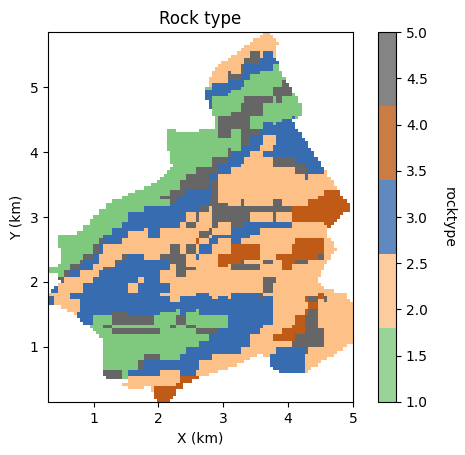

<Figure size 640x480 with 0 Axes>

In [21]:
GSLIB.pixelplt_st(array_2d,
                  df_grid['x'].min(),df_grid['x'].max(),df_grid['y'].min(),df_grid['y'].max(), #we have to use the actual min and max values
                  csize,1,5,'Rock type','X (km)','Y (km)',
                  (str(grid_feature)), cmap_cat); plt.show()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Interesting, there are a lot of local variations in our subsurface unit.

#### Visualizing Tabular and Gridded Data Together

You may be concerned about the consistency between the tabular samples and the gridded data. 

* It is a good check to plot them together. 
* GeostatsPy's locpix is a function to plot tabular and gridded data together. 

In [ ]:
GSLIB.locpix_st                                                  # GeostatsPy's combined tabular and gridded data plot

In [ ]:
print(df.columns)
cat_feature = 'Rock' # feature of interest

In [ ]:
GSLIB.locpix_st(array_2d
                , df_grid['x'].min(), df_grid['x'].max(), df_grid['y'].min(), df_grid['y'].max(),
                csize, 1, 5,
                df, 'Xloc', 'Yloc', 
                cat_feature, 'Cd','X (km)','Y (km)',
             str(cat_feature), cmap_cat); plt.show()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

What do we see?


### Bivariate Analysis

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

Cite as: Pyrcz, M.J., 2024, Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy, https://geostatsguy.github.io/GeostatsPyDemos_Book. 

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

#### Bivariate Analysis

This chapter is a tutorial for / demonstration of **Bivariate Analysis**. 

Let's start with simple bivariate scatter plots, and calculating bivariate statistics. Here's the scatter plots.

* I included code below (commented out) for writing the plot as an image file. Note, you can write to many different formats, e.g., .tif, jpg, etc. and you can also control the resolution.

* by saving in .pdf, .svg, or eps formats you create vector graphics that retain their sharpness at any resolution with economy of file size

In [ ]:
# Define feature 1 and feature 2

feature1 = 'Cd'; feature2 = 'Zn'                           # feature 1 and feature 2

In [ ]:
# if not defined yet;

unit = 'ppm'                                                # unit of measurement   

#### Visualizing Tabular Data with Location Maps

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

The new colorbar extents improves the resolution of spatial details for our property. 

We will need ranges for the other variables. I'll pick some:

In [ ]:

f1_min = df[feature1].min(); f1_max = df[feature1].max()    # range for feature 1
f2_min = df[feature2].min(); f2_max = df[feature2].max()    # range for feature 2 

f1_min_cbar = np.floor(f1_min); f1_max_cbar = np.ceil(f1_max) # range for feature 1 color bar
f2_min_cbar = np.floor(f2_min); f2_max_cbar = np.ceil(f2_max) # range for feature 2 color bar


In [ ]:
# if not defined yet;

xmin= 0; xmax = np.ceil(df.Xloc.max())                       # range of x values
ymin= 0; ymax = np.ceil(df.Yloc.max())                       # range of y values

Let's add the other properties into a composite figure with all the plots as subplots. 

* To do this we use the subplot command, in matplotlib package to prior to the figure command to indicate that the following figure is part of a subplot and we use subplots_adjust at the end to get the scaling right. 

* We can save our fancy figure to an image file with the file format and resolution that we need. 

This is great for writing reports, papers and making great looking update presentations. 

Note, in GeostatsPy, I provide additional plotting methods with and without '_st' in the name.

* with '_st' functions to 'stack' images in a composite figure. 
* without '_st' functions to produce a single image and simultaneously make a file

We can also just make a file after we make our composite plot, see below.

In [ ]:
save_to_file = False                                          # save composite image to a file?

plt.subplot(121)
GSLIB.locmap_st(df,'Xloc','Yloc', feature1, 
                xmin, xmax, ymin, ymax, # as defined earlier
                f1_min_cbar, f1_max_cbar, # adjust the color bar range
                f'{feature1}',
                'X (km)','Y (km)',
                f'{feature1} ({unit})',
                cmap
                ); add_grid()

plt.subplot(122)
GSLIB.locmap_st(df,'Xloc','Yloc', feature2, xmin, xmax, ymin, ymax,
                f2_min_cbar, f2_max_cbar,
                f'{feature2}','X (km)','Y (km)',
                f'{feature2} ({unit})', cmap); add_grid()

# plt.subplot(223)
# GSLIB.locmap_st(df,'Xloc','Yloc','Perm',xmin,xmax,ymin,ymax,permmin,permmax,'Well Data - Permeability','X(m)','Y(m)',
#                 'Permeability (mD)',cmap); add_grid()

# plt.subplot(224)
# GSLIB.locmap_st(df,'Xloc','Yloc','AI',xmin,xmax,ymin,ymax,AImin,AImax,'Well Data - Acoustic Impedance','X(m)','Y(m)',
#                 'Acoustic Impedance (kg/m2s*10^6)',cmap); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2)
if save_to_file == True:                                      # make a figure file
    plt.savefig('All_location_maps.tif',dpi=600,bbox_inches="tight")
plt.show()

Looks pretty good, eh? (yes, I am Canadian). 


#### Scatter plot

Let's visualize the data.

In [ ]:
plt.plot(df[feature1].values, df[feature2].values, 'o', label='', markerfacecolor='darkorange', markeredgecolor='black', alpha=0.8)
plt.title(f'{feature1} vs. {feature2}')
plt.xlabel(f'{feature1} ({unit})')
plt.ylabel(f'{feature2} ({unit})')
# plt.xlim([min, max])
# plt.ylim([min, max])
add_grid()
# plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.8, wspace=0.3, hspace=0.2)
#plt.savefig('Test.pdf', dpi=600, bbox_inches='tight', format='pdf')   
plt.show()


#### Correlation and Covariance

It is straight forward to calculate the covariance and correlation from the pairs of data in our dataset. Here's the covariance matrix.  

* Notice that the matrix is symmetrical? Makes sense, as the $C_{feature1,feature2} = C_{feature2,feature1}$.
* Also, note that the diagonal values ($C_{i,j}$ where $i=j$) equal to the variance.

We check the variance.

In [ ]:
print(df.iloc[:, 4:].cov())                                   # the covariance matrix for columns 3,4,5 and 6 and all rows
print(f'The variance of {feature} is ' + str(round(np.var(df[feature].values), 6)))

Here's the correlation coefficient.

In [ ]:
df.iloc[:, 4:].corr()                                         # correlation matrix

#### Visualize the Correlation Matrix

It is convenient to visualize the correlation matrix as follows.

* I added a custom colour bar to communicate significance. Demonstration only, I did not calculate confidence intervals, but that could be added.

#### Declare Functions

Let's define a single function to streamline plotting correlation matrices. I also added a convenience function to add major and minor gridlines to improve plot interpretability.

In [ ]:
def plot_corr(corr_matrix,title,limits,mask):                 # plots a graphical correlation matrix 
    my_colormap = plt.cm.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    white_low = int(128 - mask*128); white_high = int(128+mask*128)
    newcolors[white_low:white_high, :] = white                # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    m = corr_matrix.shape[0]
    im = plt.matshow(corr_matrix,fignum=0
                    #  ,vmin = -1.0*limits, # for symmetrical distribution of values, adjust to 0 for positive only
                     , vmin = 0,
                     vmax = limits,cmap = newcmp)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.colorbar(im, orientation = 'vertical')
    plt.title(title)
    for i in range(0,m):
        plt.plot([i-0.5,i-0.5],[-0.5,m-0.5],color='black')
        plt.plot([-0.5,m-0.5],[i-0.5,i-0.5],color='black')
    plt.ylim([-0.5,m-0.5]); plt.xlim([-0.5,m-0.5])

In [ ]:
corr_matrix = df.iloc[:,4:].corr()
plt.subplot(111)
plot_corr(corr_matrix,'Correlation Matrix',1.0,0.5)           # using our correlation matrix visualization function
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

To calculate a single correlation coefficient with the associate p-value for significance testing we can use SciPy's pearsonr function.

* the p-value indicates the $\alpha$ level at which we would reject the null hypothesis that the correlation coefficient is actually 0.0 and the value is due to random effect

In [ ]:
corr, corr_p_value = pearsonr(df[feature1], df[feature2])

plt.subplot(111)
plt.plot(df[feature1].values,df[feature2].values, 'o', label='', markerfacecolor='darkorange', markeredgecolor='black', alpha=0.8)
plt.title(f'{feature1} vs. {feature2}')
plt.xlabel(f'{feature1} ({unit})')
plt.ylabel(f'{feature2} ({unit})')
# plt.xlim([min,max]); plt.ylim([min,max]); 
add_grid()

plt.annotate(r'$\rho_{\phi,k}$ = ' + str(np.round(corr, 3)), xy=(0.1, 0.9), xycoords='axes fraction')
plt.annotate(r'$\rho_{\phi,k}, \alpha$ = ' + str(np.round(corr_p_value, 20)), xy=(0.1, 0.85), xycoords='axes fraction')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.3, hspace=0.2); plt.show()

The alpha value for the correlation is very small, how small? We can check it like this.

In [ ]:
corr_p_value

#### Spearman's Rank Correlation Coefficient

The Spearman’s rank correlation coefficient, provides a measure of the degree of monotonic relationship.

* Rank transform, e.g. $R_(x_i)$, sort the data in ascending order and replace the data with the index, $i=1,\ldots,n$.
* Spearman’s rank correlation coefficient is more robust in the presence of outliers and some nonlinear features than the Pearson’s correlation coefficient

Let's try out the rank correlation coefficient with SciPy's stats module function.

* it also provides a p-value for each measure for significance testing, i.e., if p-value < alpha then we reject the null hypothesis that the rank correlation coefficient is 0.0.

In [ ]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,4:]) # calculate the range correlation coefficient
rank_matrix = pd.DataFrame(rank_correlation,columns=corr_matrix.columns)
print('Rank Correlation:')
print(rank_correlation)
print('\nRank Correlation p-value:')
print(rank_correlation_pval)

#### Plot Correlation and Rank Correlation Matrices

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot correlation matrix
im1 = axes[0].imshow(corr_matrix, cmap='Reds', vmin=0, vmax=1)
axes[0].set_xticks(range(len(corr_matrix.columns)))
axes[0].set_yticks(range(len(corr_matrix.columns)))
axes[0].set_xticklabels(corr_matrix.columns, rotation=90)
axes[0].set_yticklabels(corr_matrix.columns)
axes[0].set_title('Correlation Matrix')

# Plot rank correlation matrix
im2 = axes[1].imshow(rank_matrix, cmap='Reds', vmin=0, vmax=1)
axes[1].set_xticks(range(len(rank_matrix.columns)))
axes[1].set_yticks(range(len(rank_matrix.columns)))
axes[1].set_xticklabels(rank_matrix.columns, rotation=90)
axes[1].set_yticklabels(rank_matrix.columns)
axes[1].set_title('Rank Correlation Matrix')

# Add a common colorbar
cbar = fig.colorbar(im1, ax=axes, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.9, wspace=0.3, hspace=0.3)
plt.show()


Note that the y-axis order is plotted inversely

In [ ]:
plt.subplot(221)                                              # plot correlation matrix with significance colormap
plot_corr(corr_matrix,'Correlation Matrix',1.0,0.5)           # using our correlation matrix visualization function

plt.subplot(222)                                              # plot correlation matrix with significance colormap
plot_corr(rank_matrix,'Rank Correlation Matrix',1.0,0.5)      # using our correlation matrix visualization function

plt.subplot(223)                                              # plot correlation matrix with significance colormap
diff = corr_matrix.values - rank_matrix.values
diff_matrix = pd.DataFrame(diff,columns=corr_matrix.columns)
plot_corr(diff_matrix,'Correlation - Rank Correlation',0.3,0.0) # using our correlation matrix visualization function

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.2); plt.show()

From the correlation minus rank correlation heatmap we see,

* 

#### Matrix Scatter Plots

If we have 3 or more variables to consider then matrix scatter plot offer an efficient method to display the multivariate relationships, 2 variables at a time. Once can identify:

1. the range, envelope of the paired data
2. homoscedastic and heteroscedastic behaviors
3. nonlinear features

Here's the seaborn package matrix scatter plot function, pairplot.

In [ ]:
sns.pairplot(df, vars=df.columns[4:], markers='o',
             corner=True, diag_kind='hist',
            #  , diag_kws={'bins': 20} # If you don't specify the number of bins, it will use the Freedman-Diaconis rule which is a rule of thumb for determining the number of bins in a histogram
            plot_kws={'alpha': 0.8, 'edgecolor': 'black', 'facecolor': 'darkorange'})

# Add units to the labels, in this case they all have the same unit
for ax in plt.gcf().axes:
    ax.set_xlabel(ax.get_xlabel() + f' ({unit})')
    ax.set_ylabel(ax.get_ylabel() + f' ({unit})')
             
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

We can also color our data by a categorical variable. If you have >2 categories, the histograms can get a bit messy, so we plot the as kernel density 

In [ ]:
pairplot = sns.pairplot(df, 
             hue='Rock', # color by column
             vars=df.columns[4:], markers='o', 
             palette=sns.color_palette(cmap_cat.colors), # use the Accent color palette
             corner=True, 
            #  diag_kind='hist'
            #  diag_kws={'bins': 20}
             )

# Define the mapping for the legend
legend_labels = {1.0: 'Argovian', 2.0: 'Kimmeridgian', 3.0: 'Sequanian', 4.0: 'Portlandian', 5.0: 'Quaternary'}
# Adjust the legend
for t, l in zip(pairplot._legend.texts, pairplot._legend.get_texts()):
    t.set_text(legend_labels[float(l.get_text())])

# Place the legend inside the figure
pairplot._legend.set_bbox_to_anchor((0.5, 0.85))
pairplot._legend.set_frame_on(True)
pairplot._legend.set_title('Rock Types')

plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

# Additional & alternative code sections

Please note these are optional code sections

Here's some of the NumPy statistical functions that take ndarrays as an inputs.  With these methods if you had a multidimensional array you could calculate the average by row (axis = 1) or by column (axis = 0) or over the entire array (no axis specified). We just have a 1D ndarray so this is not applicable here.

We calculate the inverse of the CDF, $F^{-1}_x(x)$ with Numpy percentile function.

In [ ]:
print('The minimum is ' + str(round(np.amin(df[feature].values),2))) # print univariate statistics
print('The maximum is ' + str(round(np.amax(df[feature].values),2)))
print('The range (maximum - minimum) is ' + str(round(np.ptp(df[feature].values),2)))
print('The P10 is ' + str(round(np.percentile(df[feature].values,10),3)))
print('The P50 is ' + str(round(np.percentile(df[feature].values,50),3)))
print('The P90 is ' + str(round(np.percentile(df[feature].values,90),3)))
print('The P13 is ' + str(round(np.percentile(df[feature].values,13),3)))
print('The median (P50) is ' + str(round(np.median(df[feature].values),3)))
print('The mean is ' + str(round(np.mean(df[feature].values),3)))

We can calculate the CDF value, $F_x(x)$, directly from the data.
* we apply a conditional statement to our ndarray to calculate a boolean ndarray with the same size of the data and then count the cases that meet the condition
* note, we are assuming equal weighting

In [ ]:
value = 0.10                                                  # calculate cumulative distribution function for a specified value
cumul_prob = np.count_nonzero(df[feature].values <= value)/len(df)
print('The cumulative probability for ' + str(feature) + ' = ' + str(value) + ' is ' + str(round(cumul_prob,2)))

#### Plotting a Histogram with the matplotlib Package

I don't want to suggest that matplotlib is hard to use. The GSLIB visualizations provide convenience and once again use the same parameters as the GSLIB methods. Particularly, the 'hist' function is pretty easy to use, just a lot more code to write.  It doens't have default values for the arguments.

* here's how we can make the same histogram as above with matplotlib directly

In [ ]:
plt.hist(df[feature].values, alpha=0.8, color="darkorange", edgecolor="black", bins=20, range=[min,max])
plt.title('Histogram'); plt.xlabel(str(feature) + ' (' + str(unit) + ')'); plt.ylabel("Frequency"); add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2); plt.show()

#### Plotting a CDF with the Matplotlib Package

Here's how we calculate and plot a CDF with matplotlib.  
* the y axis is cumulative probability with a minimum of 0.0 and maximum of 1.0 as expected for a CDF.
* note after the initial hist command we can add a variety of elements such as labels to our plot as shown below.

In [ ]:
print(df[feature].values)

In [ ]:
plt.hist(df[feature].values,density=True, cumulative=True, label='CDF',
           histtype='stepfilled', alpha=0.8, bins = 100, color='darkorange', edgecolor = 'black', range=[min, max])
plt.xlabel(str(feature) + ' (' + str(unit) + ')'); plt.title(str(feature) + ' CDF'); plt.ylabel('Cumulation Probability'); add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.1, hspace=0.2); plt.xlim([min,max]); plt.ylim([0,1])
#plt.savefig('cdf_' + str(feature) + .tif',dpi=600,bbox_inches="tight")
plt.show()

# Additional text and YouTube links from Michael Pyrcz along with the code

**YouTube Lecture**: check out my lectures on:

* [Univariate Distributions](https://youtu.be/TbqaMXdSV4I?si=tzPNssh5Qcqv6DY_)
* [Statistical Expectation](https://youtu.be/QVgMt3cPMmM?si=otR-qEN8xeEm2nbk)
* [Parametric Distributions](https://youtu.be/U7fGsqCLPHU?si=ekNqbNqUvrGdTjjG)
* [Joint, Marginal, and Conditional Probability](https://youtu.be/kxjnPVyuuo8?si=FI3Tiu72Wc5Neunm)

For convenience here's a summary of the salient points.

#### Definitions

Let's start with some basic definitions with respect to univariate, bivariate and multivariate.

* **Univariate** - involving one variable (feature) or event.

* **Univariate Statistics** - summary measures based on one feature measured over a sample

* **Univariate Parameters** - summary measures inferred for one feature measured over the population

We start with univariate, but we will cover bivariate, involving two variables (features) later. Note, joint probabilities and distributions are: 

* **Bivariate** - regarding 2 variables (features)

* **Multivariate** - the general term for $> 1$ features, but often refers to $\ge 3$ or more).

* **Massively Multivariate** - high dimensional, usually indicating 7 or more features

Now, let's describe the concept of a distribution. 

* **Statistical Distribution** – for a variable (feature) a description of the probability of occurrence over the range of possible values. What do we get from a statistical distribution?

    * what is the minimum and maximum?

    * do we have a lot of low values?

    * do we have a lot of high values?

    * do we have outliers (values that don’t make sense and need an explanation)?

**YouTube Lecture**: check out my lecture on [Q-Q and P-P Plots](https://youtu.be/wCgdoImlLY0?si=lpTWz2H7QTdxHBy9). For your convenience here's a summary of salient points.

##### QQ-Plot

The scatter plot of matching percentiles between two distribution. Why learn about QQ-Plots?

* convenient plot to compare distributions for 2 features

* a function fit to a QQ-plot is the distribution transform, forward,

$$
y = F_y^{-1}\left( F_x(x) \right)
$$

and reverse,

$$
x = F_x^{-1}\left( F_y(y) \right)
$$

##### QQ-Plot Interpretation

If the two distributions are the same, then all the percentiles will be equal and the points will all fall on the 45 degree line. Here's an example with very similar distributions. 

If the means of the two distributions are different, then the points will be shifted from the 45 degree line.

* down and right from the 45 degree line if distribution on x-axis is has a larger mean than the distribution on the y-axis

* up and left from the 45 degree line if distribution on x-axis is has a smaller mean than the distribution on the y-axis

If the variances (or standard deviations) of the two distributions are different, then the points will appear to be stretched out along the axis for the distribution with greater variance.

* difference in variance will appear like a "rotation" from the 45 degree line

Of course, both the mean and variance can be different.

Finally, it is possible for distributions to be similar and then to diverge only for part of the distribution. This will be quite clear on a QQ-plot.



**YouTube Lecture**: check out my lecture on [Displaying Data](https://youtu.be/TbqaMXdSV4I?si=UwGH-iRc7V962yNF), see the first part of this larger lecture on univariate distributions.

**YouTube Lecture**: check out my lectures on:

* [Bivariate Statistics](https://youtu.be/wZwYEDqB4A4?si=yZLaxiGMv50K841R)
* [Multivariate Analysis](https://youtu.be/Ui2El5CZPRE?si=uA_IqurENzC6Owbg)

These lectures are all part of my [Data Analytics and Geostatistics Course](https://www.youtube.com/playlist?list=PLG19vXLQHvSB-D4XKYieEku9GQMQyAzjJ) on YouTube with linked well-documented Python workflows and interactive dashboards. My goal is to share accessible, actionable, and repeatable educational content. If you want to know about my motivation, check out [Michael's Story](https://michaelpyrcz.com/my-story). 

#### Motivation for Bivariate Analysis

There are many important reasons to learn bivariate analysis methods to strengthen your foundation in geostatistics,

**Never a Single Feature** - most often we work with multiple features. It is quite rare to model a single feature as part of a geostatistical modeling workflow.

* petroleum rock and fluid system features - facies, porosity, permeability and fluid saturations

* mining deposit features - concentration of copper, nickel, silver, gold and sulfur

* agriculture soil features - pH level, soil moisture, nitrogen, phosphorus, clay content and organic matter

* forestry inventory features - tree density, species composition, tree height, basal area and above-ground biomass

Our spatial models are multivariate, so we cannot model a single feature in isolation.

**Geostatistics is Limited to Multivariate** - I do not like making this confession. While some will respond with a comment about some novel workflow that builds multivariate geostatistical models, for example [Step-wise Conditional Transform](https://link.springer.com/article/10.1023/A:1023235505120) by Dr. Leuangthong and Professor Deutsch. 

* yet, the common practice is limited to 2 features at a time, primary feature being modeled supported by a secondary feature

* this is based on variants of the cokriging system that we introduce in the [Cosimulation](GeostatsPy_cosimulation) chapter 

* a sequential approach is applied model more than 2 features, for example, simulate copper, cosimulate nickel with copper as secondary, cosimulate gold with nickel as secondary

To do this we must understand bivariate analysis methods.

#### Bivariate Analysis

Understand and quantify the relationship between two variables, i.e., the bivariate probability density function, $f_{x,y}(x,y)$, for example,

* porosity and permeability

* fraction of shale and oil recovery

* copper and gold

* basal area and tree height
  
How can we use these relationships? To improve our prediction models and ultimately make better decisions.

What would be the impact if we ignore these relationships and simply modeled each feature separately?

* **assumption of independence** - there will be no relationship between our estimates or simulated realizations, the joint probability density function will not be reproduced and unrealistic combinations may occur, e.g., very high permeability with very low porosity 

* **data conditioning** - will impose the relationship at data locations. The geostatistics models honor the data at the data locations and the data scatter plot is the correct relationship, but away from the data this relationship will fade


Bivariate statistics are our tools to quantify and impose these bivariate relationships in our geostatistical models.

#### Bivariate Statistics

**Pearson’s Product‐Moment Correlation Coefficient** or just the correlation coefficient or just correlation, is a widely-known bivariate statistic, if you say 0.9 correlation most engineers and scientists can visualize this! Here's the important points and limitations for the correlation coefficient,

* the notation for correlation is, $\rho_{x,y}$

* provides a measure of the degree of linear relationship, i.e., nonlinear relationships will bias the correlation coefficient

* is very sensitive to outliers, i.e., a single extreme outlier can significantly increase or reduce the apparent correlation

There are some other deeper points that should be made about the Gaussian assumption,

* the correlation coefficient provides a complete description for the bivariate relationship only under the assumption of bivariate Gaussianity. If we assume Gaussian, then the means, $\overline{x}$ and $\overline{y}$, standard deviations, $s_x$ and $s_y$, with the correlation coefficient, $\rho_{x,y}$ completely describe the bivariate probability density function $f_{x,y}(x,y)$

* for any other distributions, the correlation coefficient is not sufficient to know the entire, bivariate probability density function $f_{x,y}(x,y)$, e.g., to calculate conditional distributions, $f_{x|y}$

* the standard approach in geostatistics is to apply Gaussian anamorphosis to each feature and then to assume bivariate Gaussian so that the correlation coefficient is sufficient to describe the relationship between the two features

What about spatial bivariate relationship?

* the full cokriging system includes cross variograms and cross covariance that capture the relationships between two features over space! But due to the difficulty of inferring and modeling the required linear model of coregionalization, this is rarely done.

* instead a simplifying apply like collocated cokriging is applied that only retains the collocated secondary data and limits the model of bivariate relationship to the collocated (lag $\bf{h}$ of 0.0) correlation coefficient

More could be done! Let's review the sample variance of variable $x$. Of course, I'm truncating our notation as $x$ is a set of samples a locations in our modeling space, $x(\bf{u_\alpha}), \, \forall \, \alpha = 0, 1, \dots, n - 1$.

$$
\sigma^2_{x}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})^2}{(n-1)}
$$

We can expand the squared term and replace on of them with $y$, another variable in addition to $x$.

$$
C_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)}
$$

We now have a measure that represents the manner in which variables $x$ and $y$ co-vary or vary together.  We can standardized the covariance by the product of the standard deviations of $x$ and $y$ to calculate the correlation coefficient. 

$$
\rho_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)\sigma_x \sigma_y}, \, -1.0 \le \rho_{xy} \le 1.0
$$

In summary we can state that the correlation coefficient is related to the covariance as:

$$
\rho_{xy}  = \frac{C_{xy}}{\sigma_x \sigma_y}
$$

To help you calibrate you eye to the correlation coefficient I developed an interactive [correlation dashboard](https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_Correlation_Coefficient.ipynb). 

* for the bivariate Gaussian case vary the correlation coefficient and observe the samples, condition expectation and joint probability density

The Person's correlation coefficient is quite sensitive to outliers and departure from linear behavior (in the bivariate sense). 

For an more robust correlation measure in the presence of outliers and nonlinearity, we have an alternative known as the Spearman's rank correlations coefficient.   

$$
\rho_{R_x R_y}  = \frac{\sum_{i=1}^{n} (R_{x_i} - \overline{R_x})(R_{y_i} - \overline{R_y})}{(n-1)\sigma_{R_x} \sigma_{R_y}}, \, -1.0 \le \rho_{R_x,R_y} \le 1.0
$$

The rank correlation applies the rank transform to the data prior to calculating the correlation coefficient.  To calculate the rank transform simply replace the data values with the rank $R_x = 1,\dots,n$, where $n$ is the maximum value and $1$ is the minimum value. 

$$
x_\alpha, \, \forall \alpha = 1,\dots, n, \, | \, x_i \ge x_j \, \forall \, i \gt j 
$$

$$
R_{x_i} = i
$$

To compare Pearson and rank correlation in the presence of an outlier I developed this [correlation outlier dashboard](https://github.com/GeostatsGuy/DataScienceInteractivePython/blob/main/Interactive_Correlation_Coefficient_Issues.ipynb),

The correlation coefficients provide useful metrics to quantify relationships between two variables at a time. We can also consider bivariate scatter plots and matrix scatter plots to visualize multivariate data. 

* remember, current practical subsurface modeling is bivariate, two variables at a time    

#### Multivariate Statistics

While we are limited to bivariate models, we need to understand some multivariate methods to work with multivariate data. 

* only a short summary is provided here, see the discussion on joint and conditional probabilities and distributions in the [Probability Concepts](GeostatsPy_probability) chapter

* see my lecture on [Multivariate Analysis](https://youtu.be/Ui2El5CZPRE?si=uA_IqurENzC6Owbg)

Here's a short summary of multivariate statistics. If we define a probability density function (PDF) of feature $X_1$ as,

$$
f_{X_1}(x_1)
$$

we can extend the definition to a joint PDF for any arbitrary number, e.g., $m$, features as,

$$
f_{X_1,\ldots,X_m}(x_1,\ldots,x_m)
$$

Similarly, conditional PFDs can be calculated,

$$ 
f_{Y | X}(y | x)
$$

and extended to any number of features, e.g., $m$, features as,

$$ 
f_{Y | X_1, \ldots, X_m}(y | x_1,\ldots,x_m)
$$

and many of our statistical concepts extend to high dimensions, for example consider the correlation coefficient,

$$
\rho_{X,Y}
$$ 

between 2 features and now the partial correlation coefficient that calculates correlation between 2 features ($X$ and $Y$) while controlling for all other features ($Z$).

$$
\rho_{X,Y | Z}
$$ 

Ultimately the difficulty with calculating high dimensionality (massively multivariate) probabilities and statistics is inferential, we rarely have enough data to observe vast multivariate space and to model probabilities and statistics in that space! 

* See my linked lecture on the curse of dimensionality above.

# Comments

This was a basic demonstration of calculating univariate statistics and visualizing data distributions. Much more could be done, I have other demonstrations on basics of working with DataFrames, ndarrays and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy.

I hope this was helpful,

*Michael*

#### The Author:

Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
